### Portfolio of Oil Exploration Assets: Learning Options, Sequential Drilling Options and Defer Options 
####  Marco Antonio Guimarães Dias, 
#### Luigi de Magalhães Detomi Calvette
##### RO Congress - Boston 2017


[Paper](http://www.realoptions.org/openconf2017/data/papers/57.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sci
from scipy.stats import norm
import time
import winsound

In [2]:

duration = 1000  # milliseconds
freq = 440  # Hz

In [3]:
#Importar Case 
case=pd.read_csv("Case_Guy_DogFish.csv", sep=';')
case.set_index('Type', inplace=True)
case=case.astype(float).T
case

Type,DogFish
CF,0.3
I_w,80.0
q,0.2
B,620.0
Owner,0.0


In [4]:
###Dados de Entrada###
r=0.03
delta=0.038
sigma=0.3
tau=3
P=50
rho=0.6
CF=case.iloc[0,0]
q=case.iloc[2,0]
B=case.iloc[3,0]
#B=620
Iw=case.iloc[1,0]
Id=B*5.35 + 650

In [5]:
P,rho, CF,q,B,Iw,Id

(50, 0.6, 0.3, 0.2, 620.0, 80.0, 3967.0)

In [6]:
def sinal(CF,rho):
    CF_s=CF +(1-CF)*rho
    CF_ins=CF*(1-rho)
    return CF_ins,CF_s


In [7]:
def carteira(CF,q,P,B,delta,Id,Iw,r):
    #VPL=P*case.iloc[2,0]*case.iloc[3,0] - (case.iloc[3,0]*5.35 + 650)*P/50
    VPL=P*q*B*np.exp(-2*delta) - Id*np.exp(-2*r)
    #c=0.047*P+3
    #VPL=P*case.iloc[2,0]*case.iloc[3,0] - (case.iloc[3,0]*c + 650)
    
    vme=CF*VPL - Iw
    #vme=np.maximum(0,vme)
    ### retorna   VME, Valor, Investimento, (valor - FC*Id), Id+Iw
    return vme, CF*VPL, Iw, CF*P*q*B,CF*Id*np.exp(-2*r) +Iw 

In [8]:
carteira(CF,q,P,B,delta,Id,Iw,r)

(523.0841727818366, 603.0841727818366, 80.0, 1860.0, 1200.7939714186143)

In [9]:
#####Valor Beta e Valor Crítico####
def vcritico(I,r,div,sigma,tau):
    if tau <=0:
        vcrit=I
        beta= 0.5 -(r-div)/(sigma**2) + np.sqrt(np.power(((r-div)/(sigma**2)) - 0.5,2) +((2*r)/(sigma**2)))
    else:
        if div<=0:
            print("Faça um BSM")
        else:
            
            beta= 0.5 -(r-div)/(sigma**2) + np.sqrt(np.power(((r-div)/sigma**2) -0.5,2) +((2*r)/(sigma**2)))
            V_perp= I*(beta/(beta-1))
            V_0=np.maximum(I, (r/div)*I)
            ht= -1*((r-div)*tau + 2*sigma*np.sqrt(tau))*(V_0/(V_perp - V_0))
            vcrit= V_0 + (V_perp - V_0)*(1- np.exp(ht))
    return[beta,vcrit, V_perp]
            
        
        

In [10]:
####Método Black Merton e Scholes
def bsm(V,I,r,div,sigma,tau):
    #Opção de Compra Europeia com dividendos - Merton
    

    if tau <=0:
        call=np.maximum(V-I,0)
        put=np.maximum(I-V,0)
    else:
        h1=(np.log(V/I) + ((r-div) +(0.5*np.power(sigma,2)))*tau)/(sigma*np.sqrt(tau))
        h2=h1 -sigma*np.sqrt(tau)
        
        call= V*np.exp(-div*tau)*norm.cdf(h1) -I*np.exp(-r*tau)*norm.cdf(h2)
        put= call + (np.exp(-r*tau)*I - V*np.exp(-div*tau))
        put2= I*np.exp(-r*tau)*(1- norm.cdf(h2)) - V*np.exp(-div*tau)*(1-norm.cdf(h1))
    #return[call, put, norm.cdf(h1), norm.cdf(h2),put2]
    return[call, put]





In [11]:
###Função probabilidade para cálculo do gatilho pelo método de aproximação analítica
def prob(V,tau,gama,h,vcrit,r,div,sigma):
    ####Função probabilidade
    lamba=(-r +(gama*(r-div)) +0.5*gama*(gama-1)*sigma**2)*tau
    dist= -(np.log(V/h)+((r-div)+(gama - 0.5)*sigma**2)*tau)/(sigma*np.sqrt(tau))
    kappa= (2*gama -1) +  2*(r-div)/(sigma**2)
    prob=np.exp(lamba)*(V**gama)*(norm.cdf(dist) - ((vcrit/V)**kappa)*(norm.cdf(dist -(2*np.log(vcrit/V))/(sigma*np.sqrt(tau)))))
    
    return[prob]
    

In [12]:
### Método Bjerksund e Stensland (1993) - saida - Derivativo, Gatilho e V_0
def bjst(V,I,r,div,sigma,tau):
    #### Call americana
    if div <=0: #igual a call europeia
        bs=bsm(V,I,r,div,sigma,tau)[0]
    else:
        beta=vcritico(I,r,div,sigma,tau)[0]
        vcrit=vcritico(I,r,div,sigma,tau)[1]
        alpha= (vcrit - I)*vcrit**(-beta)
        
        if V>= vcrit:
            bs=V-I
        else:
            bs= alpha*V**beta -alpha*prob(V,tau,beta,vcrit,vcrit,r,div,sigma)[0]+prob(V,tau,1,vcrit,vcrit,r,div,sigma)[0]-prob(V,tau,1,I,vcrit,r,div,sigma)[0]-I*prob(V,tau,0,vcrit,vcrit,r,div,sigma)[0]+I*prob(V,tau,0,I,vcrit,r,div,sigma)[0]
    
    return[bs, vcrit, V]
    
    

In [13]:
##################################################3
#####################################################
###########Solucao e_ DF ##############


In [14]:
def diffinexpcart(P,I,r,div,sigma,tau,accur):
    #############################################################
    #######Método por diferenças finitas explícitas##############
    #accur=0.05  #Porcentagem de acurácia
    
    #####Solução por diferenças finita explícitas###
    #Precisão em e intervalo da célula em V
    deltaP=P*accur
    
    # M são as divisões do grid em V
    #Perpetuidade vcritico não esta na programacao
    #M= int(1.1*vcritico(I,r,div,sigma,tau)[2]/deltaV) # Max é 10% acima do gatilho em perpetuidade. Vcrit- com gati precisa de tau
    M=int(2*vcritico(I,r,div,sigma,tau)[2]/deltaP)
    #PGrid=int(P/deltaP) #Ponto do grid onde esta P_0. 
    #deltat= (deltaP**2)/((sigma**2)*((3*I)**2)) #Convergência: Critério do peso central >=0. Pmax=3I ><1.1Gatilho_perp
    deltat= (deltaP**2)/((sigma**2)*((3*I)**2))
    N= int(tau/deltat) +1
    
    df=1/(1+(r*deltat)) # fator de desconto
    
    
    #Vetor Pt
    Pt=np.zeros(M+1)
    Gatilho=np.zeros((N+1))
    F=np.zeros((N+1,M+1))
    deltat=tau/N
    for i in range(M+1):
        Pt[i]= i*deltaP
        F[N,i]=np.maximum(Pt[i]-I,0) 
    Gatilho[N]=I
        #Gatilho[N]=I
    
    
    #print(PGrid,Pt.shape)
    PGrid=np.where(np.round(Pt,2)==np.round(P,2))[0][0]
    ##############Loop################
    for j in range(N-1,-1,-1): #de N-1 até zero(-1) pulando em -1
        for i in range(1,M,1): # de 1 até M-1 pulando em 1
            pu= 0.5*((sigma**2)*(i**2) + ((r - div)*i))*deltat
            pm = 1 - (sigma**2)*(i**2)*deltat
            pdown = 0.5*((sigma**2)*(i**2) - ((r - div)*i))*deltat
            F[j,i]= df*(pu*F[j+1,i+1] + pm*F[j+1,i] + pdown*F[j+1,i - 1])
            
            ###Vetor Gatilho####
            if F[j,i]<Pt[i]-I  and F[j,i-1]>Pt[i-1]-I :
                Gatilho[j]=(Pt[i-1] +Pt[i])*.5
            F[j,i]=np.maximum(Pt[i]-I,F[j,i])
            
           
        
        F[j,0]=0
        F[j,M]=Pt[i]-I
        
    T=np.linspace(0,tau,num=N+1)
    return[F[0,PGrid],PGrid,F,T,Pt,Gatilho]



In [15]:
#accur=0.005
accur=0.005

In [16]:

V_cf=CF*P*q*B*np.exp(-2*delta)
Id_cf=CF*Id*np.exp(-2*r)


In [17]:
start=time.time()
opcao,PGrid,mapa,tempo,preco,gatilho=diffinexpcart(V_cf,Id_cf+Iw,r,delta,sigma,tau,accur)
cpu=time.time()-start
print('minutos-',cpu/60)

winsound.Beep(freq, duration)


minutos- 4.076100047429403


In [18]:
V_cf, preco[PGrid]

(1723.878144200451, 1723.8781442004513)

In [19]:
preco=preco/(CF*q*B*np.exp(-2*delta))

In [20]:
g=gatilho/(CF*q*B*np.exp(-2*delta))

gatilho é: 69.62500000000003
opcao vale: 581.2829731756544


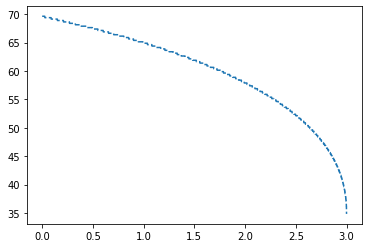

In [21]:
print('gatilho é:',gatilho[0]/(CF*q*B*np.exp(-2*delta)))
print('opcao vale:', opcao)
#plt.plot(tempo[:-1],g[:-1], ls='--')
plt.plot(tempo,g, ls='--')


In [22]:
np.round(carteira(CF,q,g[0],B,delta,Id,Iw,r)[0],2)


1199.71

In [23]:
for i in range(280,400):
    print ('preco',np.round(preco[i],2), 'opcao', np.round(mapa[0,i],2),'vme', np.round(carteira(CF,q,preco[i],B,delta,Id,Iw,r)[0],2), 'diff',np.round(mapa[0,i]-carteira(CF,q,preco[i],B,delta,Id,Iw,r)[0],2))

preco 70.0 opcao 1212.64 vme 1212.64 diff 0.0
preco 70.25 opcao 1221.25 vme 1221.25 diff 0.0
preco 70.5 opcao 1229.87 vme 1229.87 diff 0.0
preco 70.75 opcao 1238.49 vme 1238.49 diff 0.0
preco 71.0 opcao 1247.11 vme 1247.11 diff 0.0
preco 71.25 opcao 1255.73 vme 1255.73 diff -0.0
preco 71.5 opcao 1264.35 vme 1264.35 diff -0.0
preco 71.75 opcao 1272.97 vme 1272.97 diff 0.0
preco 72.0 opcao 1281.59 vme 1281.59 diff 0.0
preco 72.25 opcao 1290.21 vme 1290.21 diff 0.0
preco 72.5 opcao 1298.83 vme 1298.83 diff -0.0
preco 72.75 opcao 1307.45 vme 1307.45 diff -0.0
preco 73.0 opcao 1316.07 vme 1316.07 diff 0.0
preco 73.25 opcao 1324.69 vme 1324.69 diff 0.0
preco 73.5 opcao 1333.31 vme 1333.31 diff 0.0
preco 73.75 opcao 1341.93 vme 1341.93 diff 0.0
preco 74.0 opcao 1350.55 vme 1350.55 diff -0.0
preco 74.25 opcao 1359.17 vme 1359.17 diff -0.0
preco 74.5 opcao 1367.78 vme 1367.78 diff -0.0
preco 74.75 opcao 1376.4 vme 1376.4 diff -0.0
preco 75.0 opcao 1385.02 vme 1385.02 diff 0.0
preco 75.25 opcao 

In [24]:
preco[288]

72.00000000000001

In [25]:
np.where(preco>71.87)

(array([288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300,
        301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
        314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
        327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
        353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
        366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378,
        379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
        392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
        405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417,
        418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430,
        431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,
        444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,
        457, 458, 459, 460, 461, 462, 463, 464, 465

(-5, 80)

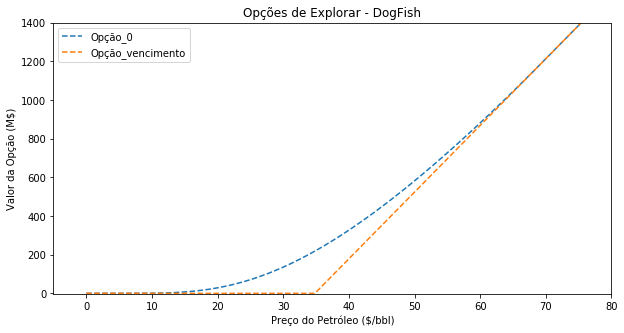

In [26]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(preco,mapa[0,:], ls='--')

#ax.plot(preco,venc, ls='--')
ax.plot(preco,mapa[-1,:], ls='--')

plt.legend(['Opção_0','Opção_vencimento'])
ax.set_title('Opções de Explorar - DogFish')
ax.set_ylabel('Valor da Opção (M\$)')
ax.set_xlabel('Preço do Petróleo (\$/bbl)')

ax.set_ylim(-5,1400)
ax.set_xlim(-5,80)



In [27]:

V_inv=P*q*B*np.exp(-2*delta)
Id_inv=Id*np.exp(-2*r)


In [28]:
start=time.time()
opcao_inv,PGrid_inv,mapa_inv,tempo_inv,preco_inv,gatilho_inv=diffinexpcart(V_inv,Id_inv,r,delta,sigma,tau,accur)
cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)



minutos- 3.2870959957440693


In [29]:
V_inv, preco_inv[PGrid_inv]

(5746.26048066817, 5746.26048066817)

In [30]:
preco_inv=preco_inv/(q*B*np.exp(-2*delta))

In [31]:
g_inv=gatilho_inv/(q*B*np.exp(-2*delta))

In [32]:
len(preco)

747

In [33]:
valor_vme=[]
for i in range(len(preco)):
    valor_vme.append(carteira(CF,q,preco[i],B,delta,Id,Iw,r)[0])

Text(0.5, 0, 'Preço do Petróleo (\\$/bbl)')

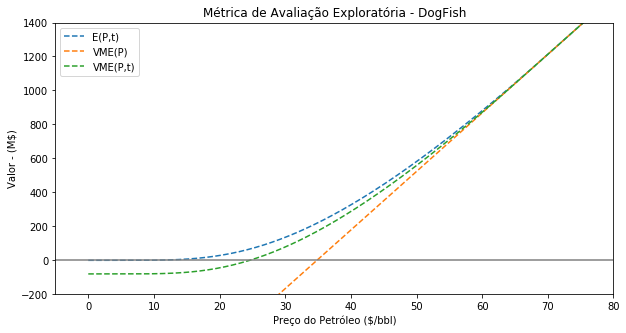

In [34]:
fig,ax=plt.subplots(figsize=(10,5))

ax.plot(preco,mapa[0,:], ls='--')
ax.plot(preco,valor_vme, ls='--')
ax.plot(preco_inv,CF*mapa_inv[0,:] - Iw, ls='--')

ax.axhline(0, linestyle='-', color='grey')



#ax.plot(preco,venc, ls='--')
#ax.plot(preco_inv/(0.1*300*np.exp(-2*delta)),mapa_inv[-1,:], ls='--')

plt.legend(['E(P,t)','VME(P)', 'VME(P,t)'])
ax.set_ylim(-200,1400)
ax.set_xlim(-5,80)
ax.set_title('Métrica de Avaliação Exploratória - DogFish')

ax.set_ylabel('Valor - (M\$)')
ax.set_xlabel('Preço do Petróleo (\$/bbl)')



In [35]:
VME=CF*opcao_inv -Iw
print(VME)
print(g_inv[0])

558.2340820237011
64.875


In [36]:
if P>g[0]:
    custo=VME*(1-np.exp(-r/12))
else:
    custo=0

In [37]:
sinal(CF,rho)

(0.12, 0.72)

In [38]:
start=time.time()

opcao_up,PGrid_up,mapa_up,tempo_up,preco_up,gatilho_up=diffinexpcart(sinal(CF,rho)[1]*P*q*B*np.exp(-2*delta),sinal(CF,rho)[1]*Id*np.exp(-2*r)+Iw,r,delta,sigma,tau,accur)
opcao_down,PGrid_down,mapa_down,tempo_down,preco_down,gatilho_down=diffinexpcart(sinal(CF,rho)[0]*P*q*B*np.exp(-2*delta),sinal(CF,rho)[0]*Id*np.exp(-2*r)+Iw,r,delta,sigma,tau,accur)
opcao_info=CF*opcao_up + (1-CF)*opcao_down

cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)



minutos- 10.391580200195312


In [39]:
preco_up=preco_up/(sinal(CF,rho)[1]*q*B*np.exp(-2*delta))
preco_down=preco_down/(sinal(CF,rho)[0]*q*B*np.exp(-2*delta))

In [40]:
F_up_zero=np.interp(preco_inv,preco_up,mapa_up[0,:])
F_down_zero=np.interp(preco_inv,preco_down,mapa_down[0,:])
F_zero=CF*F_up_zero+ (1-CF)*F_down_zero

Exp_zero=np.interp(preco_inv,preco,mapa[0,:])

L_zero=CF*mapa_inv[0,:] - Iw


In [41]:
mapa_up[0,:].shape, mapa_inv[0,:].shape

((718,), (697,))

In [42]:
####Até onde vai a guerra de atrito?? P_atrito
pa=preco_inv[F_zero-L_zero<0.01][0]
print(pa)

76.25000000000001


In [43]:
for i in range(len(preco_inv)):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [44]:
start=time.time()
rho1=0.6
opcao_up_n,PGrid_up_n,mapa_up_n,tempo_up_n,preco_up_n,gatilho_up_n=diffinexpcart(sinal(CF,rho1)[1]*P*q*B*np.exp(-2*delta),sinal(CF,rho1)[1]*Id*np.exp(-2*r)+Iw,r,delta,sigma,tau,accur)
opcao_down_n,PGrid_down_n,mapa_down_n,tempo_down_n,preco_down_n,gatilho_down_n=diffinexpcart(sinal(CF,rho1)[0]*P*q*B*np.exp(-2*delta),sinal(CF,rho1)[0]*Id*np.exp(-2*r)+Iw,r,delta,sigma,tau,accur)
opcao_info_n=CF*opcao_up_n + (1-CF)*opcao_down_n

cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)

minutos- 22.308750176429747


In [45]:
preco_up_n=preco_up_n/(sinal(CF,rho1)[1]*q*B*np.exp(-2*delta))
preco_down_n=preco_down_n/(sinal(CF,rho1)[0]*q*B*np.exp(-2*delta))

In [46]:
F_up_zero_n=np.interp(preco_inv,preco_up_n,mapa_up_n[0,:])
F_down_zero_n=np.interp(preco_inv,preco_down_n,mapa_down_n[0,:])
F_zero_n=CF*F_up_zero_n+ (1-CF)*F_down_zero_n


In [47]:
F_zero_n.size, L_zero.size

(697, 697)

In [48]:
import nashpy as nash

In [49]:

matrix=np.zeros((len(preco_inv),6))
for loc in range(len(preco_inv)):    
    #P1=50
    #loc=np.where(np.round(preco_inv,2)==P1)[0][0]
    #print(preco_inv[loc])
    
    VME=L_zero[loc]
    opcao_info=F_zero[loc]
    opcao=Exp_zero[loc]
    
    if preco_inv[loc]>g[0]:
        custo=VME*(1-np.exp(-r/12))
    else:
        custo=0
        
        

    #Ações do jogador 1
    A_matrix=[[VME, VME],[opcao_info,opcao-custo]]
    A_matrix=np.round(A_matrix,2)


    ###Ações do Jogador 2
    B_matrix=[[VME,opcao_info],[VME,opcao-custo]]
    B_matrix=np.round(B_matrix,2)
    war_att=nash.Game(A_matrix,B_matrix)

    eq=list(war_att.support_enumeration())
    #print(eq)


    suporte=[[1,2],[3,4]]
    
    matrix[loc,0]=preco_inv[loc]
    i=1
    for s1,s2 in eq:
        quadrante=np.dot(np.dot(s1,suporte),s2)
        #print(i)
        matrix[loc,i]=quadrante
        i=i+1
        

In [50]:
df=pd.DataFrame(matrix)

In [51]:
df.head()

,0,1,2,3,4,5
0,0.00,4.0,0.0,0.0,0.0,0.0
1,0.25,4.0,0.0,0.0,0.0,0.0
2,0.50,4.0,0.0,0.0,0.0,0.0
3,0.75,4.0,0.0,0.0,0.0,0.0
4,1.00,4.0,0.0,0.0,0.0,0.0


In [52]:
df=df.set_index(0)

In [53]:
df[df==0]=np.nan

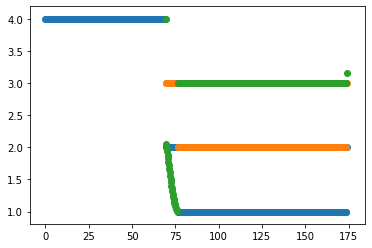

In [54]:
plt.scatter(df.index, df.iloc[:,0])
plt.scatter(df.index, df.iloc[:,1])
plt.scatter(df.index, df.iloc[:,2])
plt.scatter(df.index, df.iloc[:,3])
plt.scatter(df.index, df.iloc[:,4])



[]

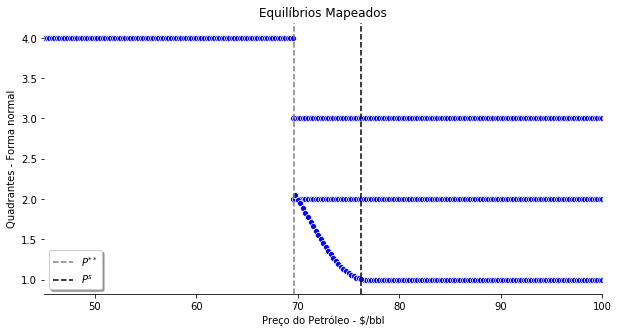

In [55]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

#ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')
#ax.axvline(x=g1[0], linestyle='-', color='grey')
#ax.axvline(x=pa1, linestyle='-', color='black')


ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(x=pa, linestyle='--', color='black')

sns.scatterplot(df.index, df.iloc[:,0], color='blue')
sns.scatterplot(df.index, df.iloc[:,1], color='blue')
sns.scatterplot(df.index, df.iloc[:,2], color='blue')
sns.scatterplot(df.index, df.iloc[:,3], color='blue')
sns.scatterplot(df.index, df.iloc[:,4], color='blue')


#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['$P^{**}$','$P^s$'], loc='lower left', shadow=True)
ax.set_xlabel('Preço do Petróleo - $/bbl')
ax.set_ylabel('Quadrantes - Forma normal')
ax.set_xlim(45,100)

ax.set_title('Equilíbrios Mapeados')

plt.plot()

In [56]:
######Até onde vai a guerra de atrito

preco_inv[F_zero_n-L_zero<0.01][0]


76.25000000000001

In [57]:
preco_inv[np.where(L_zero==Exp_zero)[0][0]]

69.75

In [58]:
F_zero.shape, Exp_zero.shape

((697,), (697,))

In [59]:
U_1=np.maximum(0, L_zero+ F_zero_n)

In [60]:
U_1_i=U_1*.5

In [90]:
U=np.maximum(0, L_zero+ F_zero)

In [91]:
U[np.where(np.round(preco_inv,2)==np.round(P,2))[0][0]]*.5

569.9743384880734

In [92]:
U[np.where(np.round(preco_inv,2)==np.round(72,2))[0][0]]*.5

1281.5905562300352

In [93]:
U[np.where(np.round(preco_inv,2)==np.round(80,2))[0][0]]*.5

1557.4110593021076

In [94]:
U_1[np.where(np.round(preco_inv,2)==np.round(P,2))[0][0]]*.5

570.8022472080579

In [95]:
U_1[np.where(np.round(preco_inv,2)==np.round(72,2))[0][0]]*.5

1281.9552860747046

In [96]:
np.where(np.round(preco_inv,2)==np.round(P,2))[0][0]
print(preco_inv[np.where(np.round(preco_inv,2)==np.round(P,2))[0][0]])

50.00000000000001


In [97]:
w_i=0.5

In [98]:
U_i=U*w_i

In [99]:
preco[np.where(U_i>0)[0][0]]

21.250000000000004

[]

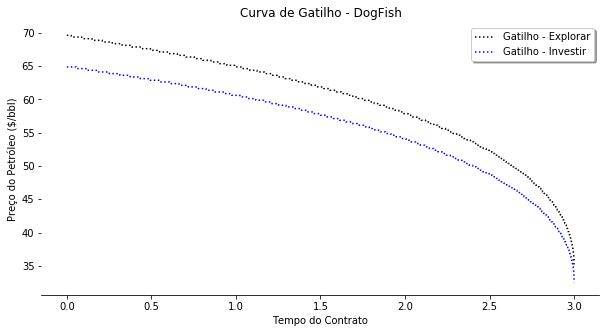

In [100]:
#####Figuras de Gatilho e a#####
fig, ax= plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

#print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
#print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))

ax.plot(tempo,g, color='black', ls=':' )
ax.plot(tempo_inv,g_inv, color='blue', ls=':' )

ax.legend(['Gatilho - Explorar','Gatilho - Investir'], loc='upper right', shadow=True)

ax.set_xlabel('Tempo do Contrato')
ax.set_ylabel('Preço do Petróleo (\$/bbl)')
#ax1.set_xticklabels([0,1000,2000,5000,10000,50000,100000])
ax.set_title('Curva de Gatilho - DogFish')

plt.plot()

gatilho explorar hoje é: 69.63
gatilho investir hoje é: 64.88


[]

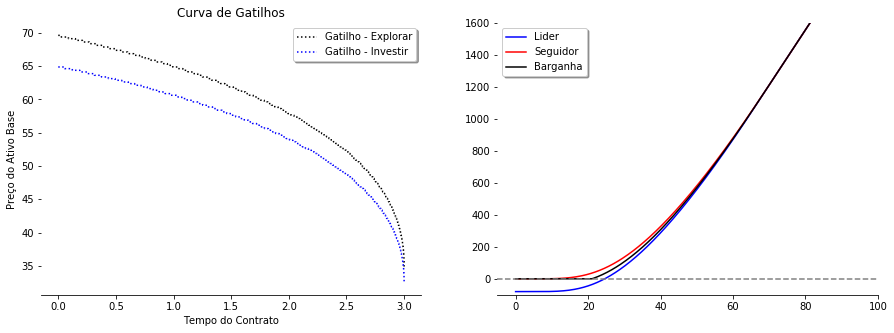

In [101]:
#####Figuras de Gatilho e a#####
fig, (ax1,ax2)= plt.subplots(1,2, figsize=(15,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))

ax1.plot(tempo,g, color='black', ls=':' )
ax1.plot(tempo_inv,g_inv, color='blue', ls=':' )

ax1.legend(['Gatilho - Explorar','Gatilho - Investir'], loc='upper right', shadow=True)

ax1.set_xlabel('Tempo do Contrato')
ax1.set_ylabel('Preço do Ativo Base')
#ax1.set_xticklabels([0,1000,2000,5000,10000,50000,100000])
ax1.set_title('Curva de Gatilhos')


ax2.plot(preco_inv,L_zero, color='blue', ls='-' )
ax2.plot(preco_inv,F_zero, color='red', ls='-' )
ax2.plot(preco_inv,U_i,color='black',ls='-')
ax2.axhline(0, linestyle='--', color='grey')

ax2.set_ylim(-20,250)
ax2.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
#ax2.set_xlabel('Preço do Ativo Base')
#ax2.set_ylabel('Valor da Opção')
ax2.set_xlim(right=100)
ax2.set_ylim(top=1600)
ax2.set_ylim(bottom=-100)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

In [102]:
#####Exploracao com custo
EXP_custo=[]
for i in range(len(preco_inv)):
    if preco_inv[i]>g[0]:
        c=L_zero[i]*(1-np.exp(-r/12))
    else:
        c=0
    #print(c)
    EXP_custo.append(Exp_zero[i]-c)


gatilho explorar hoje é: 69.63
gatilho investir hoje é: 64.88
saida do atrito - gatilho simultaneo: 71.5


[]

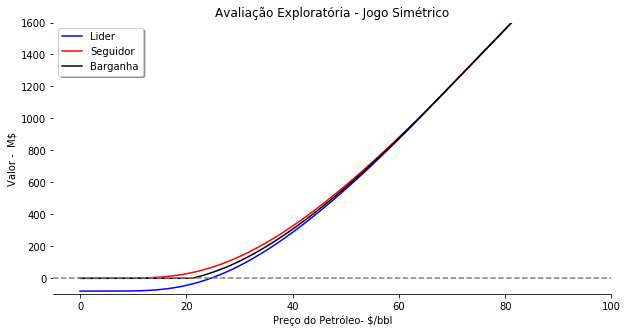

In [103]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))
print('saida do atrito - gatilho simultaneo:',round(pa,2))


ax.plot(preco_inv,L_zero, color='blue', ls='-' )
ax.plot(preco_inv,F_zero, color='red', ls='-' )
ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axhline(0, linestyle='--', color='grey')
#ax.axvline(x=g[0], linestyle='--', color='grey')
#ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.set_xlabel('Preço do Petróleo- $/bbl')
ax.set_ylabel('Valor -  M$')
ax.set_title('Avaliação Exploratória - Jogo Simétrico')
ax.set_xlim(right=100)
ax.set_ylim(top=1600)
ax.set_ylim(bottom=-100)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

gatilho explorar hoje é: 69.63
gatilho investir hoje é: 64.88
saida do atrito - gatilho simultaneo: 71.5


[]

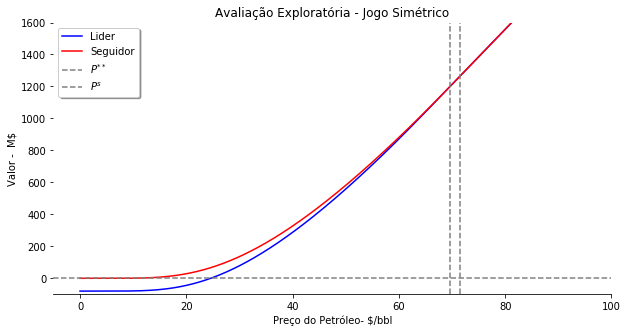

In [104]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))
print('saida do atrito - gatilho simultaneo:',round(pa,2))


ax.plot(preco_inv,L_zero, color='blue', ls='-' )
ax.plot(preco_inv,F_zero, color='red', ls='-' )
#ax2.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axhline(0, linestyle='--', color='grey')
ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['Lider','Seguidor', '$P^{**}$', '$P^{s}$'], loc='upper left', shadow=True)
ax.set_xlabel('Preço do Petróleo- $/bbl')
ax.set_ylabel('Valor -  M$')
ax.set_title('Avaliação Exploratória - Jogo Simétrico')

ax.set_xlim(right=100)
ax.set_ylim(top=1600)
ax.set_ylim(bottom=-100)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

gatilho explorar hoje é: 69.63
gatilho investir hoje é: 64.88
saida do atrito - gatilho simultaneo: 71.5


[]

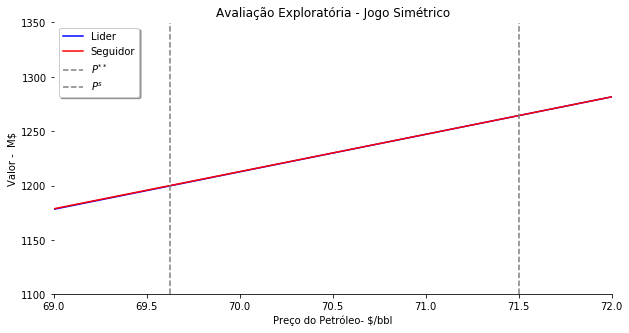

In [105]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))
print('saida do atrito - gatilho simultaneo:',round(pa,2))


ax.plot(preco_inv,L_zero, color='blue', ls='-' )
ax.plot(preco_inv,F_zero, color='red', ls='-' )
#ax2.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axhline(0, linestyle='--', color='grey')
ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['Lider','Seguidor', '$P^{**}$', '$P^{s}$'], loc='upper left', shadow=True)
ax.set_xlabel('Preço do Petróleo- $/bbl')
ax.set_ylabel('Valor -  M$')
ax.set_title('Avaliação Exploratória - Jogo Simétrico')
ax.set_xlim(right=72)
ax.set_xlim(left=69)

ax.set_ylim(top=1350)
ax.set_ylim(bottom=1100)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

gatilho explorar hoje é: 69.63
gatilho investir hoje é: 64.88
saida do atrito - gatilho simultaneo: 71.5


[]

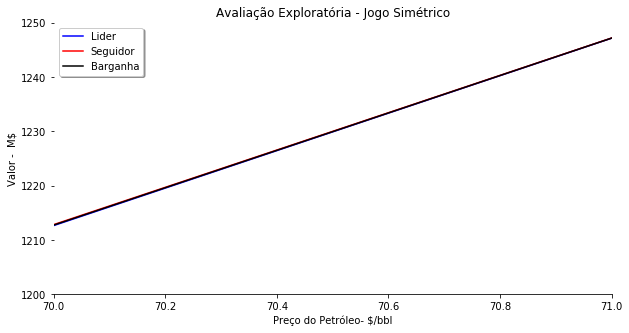

In [106]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))
print('saida do atrito - gatilho simultaneo:',round(pa,2))


ax.plot(preco_inv,L_zero, color='blue', ls='-' )
ax.plot(preco_inv,F_zero, color='red', ls='-' )
ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axhline(0, linestyle='--', color='grey')
ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.set_xlabel('Preço do Petróleo- $/bbl')
ax.set_ylabel('Valor -  M$')
ax.set_title('Avaliação Exploratória - Jogo Simétrico')
ax.set_xlim(right=71)
ax.set_xlim(left=70)

ax.set_ylim(top=1250)
ax.set_ylim(bottom=1200)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

gatilho explorar hoje é: 69.63
gatilho investir hoje é: 64.88
saida do atrito - gatilho simultaneo: 71.5


[]

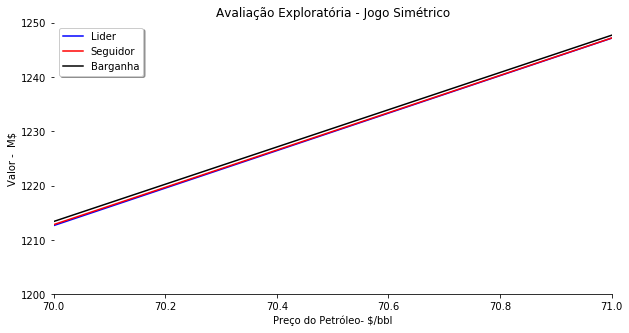

In [107]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))
print('saida do atrito - gatilho simultaneo:',round(pa,2))


ax.plot(preco_inv,L_zero, color='blue', ls='-' )
ax.plot(preco_inv,F_zero, color='red', ls='-' )
ax.plot(preco_inv,U_1_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axhline(0, linestyle='--', color='grey')
ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.set_xlabel('Preço do Petróleo- $/bbl')
ax.set_ylabel('Valor -  M$')
ax.set_title('Avaliação Exploratória - Jogo Simétrico')
ax.set_xlim(right=71)
ax.set_xlim(left=70)

ax.set_ylim(top=1250)
ax.set_ylim(bottom=1200)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

In [108]:
preco_inv[(U_1_i>F_zero)] | preco_inv[(U_1_i>U_i)]

TypeError: ufunc 'bitwise_or' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
preco_inv[np.logical_and((U_1_i>F_zero),(U_1_i>U_i))]

In [ ]:
preco_inv[U_1_i>F_zero]

In [ ]:
np.logical_and((U_1_i>F_zero),(U_1_i>U_i))

In [ ]:
########################Guerra de Atrito##############################3

In [78]:
print(opcao)
print(opcao_info)
print(custo)
print(VME)

4798.301970398955
4798.301970398955
11.937729592834673
4781.06318895695


In [79]:
import nashpy as nash

In [80]:
A_matrix=[[VME, VME],[opcao_info,opcao-custo]]
A_matrix=np.round(A_matrix,2)

In [81]:
B_matrix=[[VME,opcao_info],[VME,opcao-custo]]
B_matrix=np.round(B_matrix,2)

In [82]:
war_att=nash.Game(A_matrix,B_matrix)
war_att

Bi matrix game with payoff matrices:

Row player:
[[4781.06 4781.06]
 [4798.3  4786.36]]

Column player:
[[4781.06 4798.3 ]
 [4781.06 4786.36]]

In [83]:
eq=list(war_att.support_enumeration())
eq

[(array([0., 1.]), array([0., 1.]))]

In [84]:
for s1,s2 in eq:
    row_util=np.dot(np.dot(s1,A_matrix),s2)
    col_util=np.dot(np.dot(s1,B_matrix),s2)
    print(row_util,col_util)

4786.36 4786.36


In [ ]:
###P gatilho exploratorio
g[0]

In [ ]:
###################################Simulações da Guerra de Atrito##############################################

In [85]:
P1=72
loc=np.where(np.round(preco_inv,2)==P1)[0][0]

In [86]:
VME1=L_zero[loc]
opcao_info1=F_zero[loc]
opcao1=Exp_zero[loc]



In [87]:
if P1>g[0]:
    custo1=VME1*(1-np.exp(-r/12))
else:
    custo1=0

In [88]:
A_matrix=[[VME1, VME1],[opcao_info1,opcao1-custo1]]
A_matrix=np.round(A_matrix,2)

In [89]:
B_matrix=[[VME1,opcao_info1],[VME1,opcao1-custo1]]
B_matrix=np.round(B_matrix,2)
war_att=nash.Game(A_matrix,B_matrix)
war_att



Bi matrix game with payoff matrices:

Row player:
[[1281.59 1281.59]
 [1282.32 1278.39]]

Column player:
[[1281.59 1282.32]
 [1281.59 1278.39]]

In [90]:
eq=list(war_att.support_enumeration())
eq

[(array([1., 0.]), array([0., 1.])),
 (array([0., 1.]), array([1., 0.])),
 (array([0.81424936, 0.18575064]), array([0.81424936, 0.18575064]))]

In [99]:
for s1,s2 in eq:
    row_util=np.dot(np.dot(s1,A_matrix),s2)
    col_util=np.dot(np.dot(s1,B_matrix),s2)
    print(s1,s2,row_util,col_util)

[1. 0.] [0. 1.] 1281.59 1282.32
[0. 1.] [1. 0.] 1282.32 1281.59
[0.5, 0.5] [0.5, 0.5] 1280.9724999999999 1280.9724999999999


In [97]:
eq[2]= [0.5, 0.5], [0.5, 0.5]

In [98]:
eq

[(array([1., 0.]), array([0., 1.])),
 (array([0., 1.]), array([1., 0.])),
 ([0.5, 0.5], [0.5, 0.5])]

In [ ]:
# bjst(V,I,r,div,sigma,tau):
#valor da opção
bjst(V_cf,Iw+Id_cf,r,delta,sigma,3)

In [132]:
vcritico(Iw+Id_cf,r,delta,sigma,tau+2)[1]/(CF*q*B*np.exp(-2*delta))

69.55766396918423

In [64]:

(CF*q*B*np.exp(-2*delta))

array([[16.99424099, 15.91862444],
       [16.93376623, 15.91862444]])

In [125]:
# bjst(V,I,r,div,sigma,tau):
#valor da opção
bjst(V,Iw+Id,r,delta,sigma,2)[1]/(0.2*0.1*300*np.exp(-2*delta))

NameError: name 'V' is not defined

In [30]:
opcao - bjst(V,Iw+Id,r,delta,sigma,2)[0]

NameError: name 'opcao' is not defined

In [22]:
##############Simulacao de MCarlo

In [23]:
delta_t=tempo[1]-tempo[0]

In [24]:
tempo[2]-tempo[1]==delta_t

True

In [25]:
alpha=0.09
T=tau

In [26]:
#################Simulação MGB################

In [28]:
serie_gatilho=[]
Po=P
serie=[]
Tempo=[]
np.random.seed(57)  # Da figura
#np.random.seed(70) ###Toque no 2.99
#np.random.seed(68) ### Sem toque na curva

serie.append(Po)
Tempo.append(0)
for t in range(int(T/delta_t)):
    P1=Po*np.exp( (alpha-0.5*np.power(sigma,2))*delta_t + sigma*np.random.normal(0,1)*np.sqrt(delta_t))
    serie.append(P1)
    Po=P1
    Tempo.append((t+1)*delta_t)

df=pd.DataFrame(serie)

for i in range(len(Tempo)):
    Tempo[i] == round(i,0) #tries to round all numbers.

df=pd.DataFrame(Tempo)
df.columns=['Time']
df = df.set_index('Time')
df['S_00']=serie

       
    

In [29]:
df.head()

,S_00
Time,
0.000000,50.000000
0.000254,49.969226
0.000509,49.921843
0.000763,49.520285
0.001018,49.332956


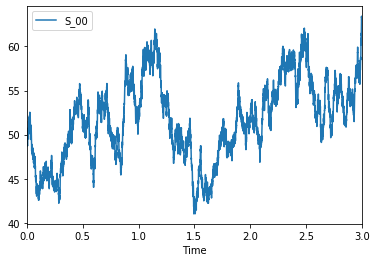

In [30]:
df.plot()

In [31]:
df['Gatilho']=g

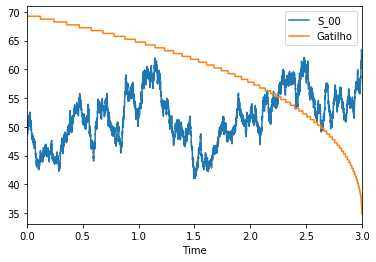

In [32]:
df.plot()

In [33]:
if df.index[df['Gatilho']<df['S_00']].shape ==(0,):
    gatilho=np.nan
    serie_gatilho.append(gatilho)
else:
    gatilho=df.index[df['Gatilho']<df['S_00']][0]
    serie_gatilho.append(gatilho)

In [34]:
serie_gatilho

[2.1552879314731572]

In [186]:
df['Processo_Antes']=df['S_00'][df.index<gatilho]

In [187]:
df['Processo_Depois']=df['S_00'][df.index>gatilho]

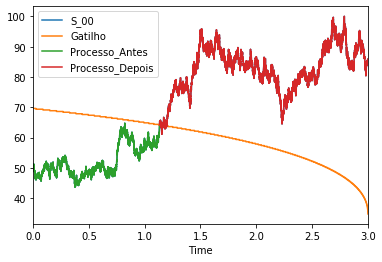

In [188]:
df.plot()

[]

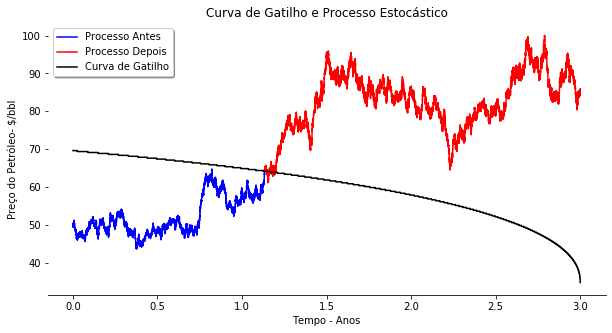

In [191]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)


ax.plot(df.Processo_Antes, color='blue', ls='-' )

ax.plot(df.Processo_Depois, color='red', ls='-' )

ax.plot(df.Gatilho, color='black', ls='-' )

ax.legend(['Processo Antes','Processo Depois','Curva de Gatilho'], loc='upper left', shadow=True)
ax.set_ylabel('Preço do Petróleo- $/bbl')
ax.set_xlabel('Tempo - Anos')
ax.set_title('Curva de Gatilho e Processo Estocástico')
#ax.set_xlim(right=72)
#ax.set_xlim(left=71)

#ax.set_ylim(top=1300)
#ax.set_ylim(bottom=1250)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

In [35]:
for i in range(9999):
    Po=P
    serie=[]
    serie.append(Po)
    for t in range(int(T/delta_t)):
        P1=Po*np.exp( (alpha -0.5*np.power(sigma,2))*delta_t + sigma*np.random.normal(0,1)*np.sqrt(delta_t))
        serie.append(P1)
        Po=P1
    df['S_{}'.format(i)]=serie
    if df.index[df['Gatilho']<df['S_{}'.format(i)]].shape ==(0,):
        serie_gatilho.append(np.nan)
    else:
        gatilho=df.index[df['Gatilho']<df['S_{}'.format(i)]][0]
        serie_gatilho.append(gatilho)
        
    
    
    

In [36]:
winsound.Beep(freq, duration)


In [37]:
len(serie_gatilho)

10000

C:\Users\LG\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\LG\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


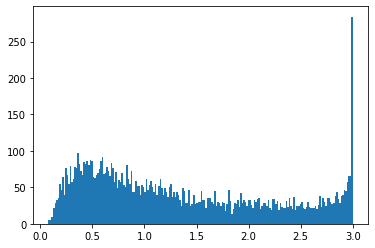

In [38]:
plt.hist(serie_gatilho, bins=200);

In [40]:
a=np.array(serie_gatilho)

In [44]:
np.isnan(a).sum()/a.shape[0]

0.1325

In [43]:
a.shape[0]

10000

In [60]:
a[~np.isnan(a)].mean()

1.3515122094050631

In [81]:
100*100/a.shape[0]

1.0

In [45]:
from matplotlib.ticker import PercentFormatter

In [47]:
tamanho=a.shape[0]

Text(0.5, 0.0125, 'min.   -    0.08')

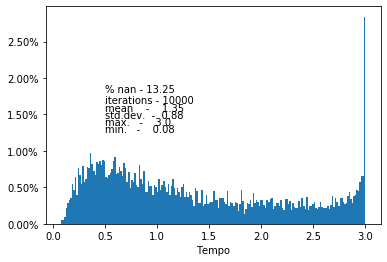

In [77]:
m=np.round(a[~np.isnan(a)].mean(),2)
dv=np.round(a[~np.isnan(a)].std(),2)
ma=np.round(a[~np.isnan(a)].max(),2)
mi=np.round(a[~np.isnan(a)].min(),2)

plt.hist(a, bins=200, weights=np.ones(tamanho)/tamanho )
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Tempo')
plt.text(0.5,.01650,'iterations - {}'.format(tamanho))
plt.text(0.5,.018,'% nan - {}'.format(100*np.isnan(a).sum()/tamanho))
plt.text(0.5,.01550,'mean    -    {}'.format(m))

plt.text(0.5,.01450,'std.dev.  -  {}'.format(dv))

plt.text(0.5,.01350,'max.   -    {}'.format(ma))

plt.text(0.5,.01250,'min.   -    {}'.format(mi))

[]

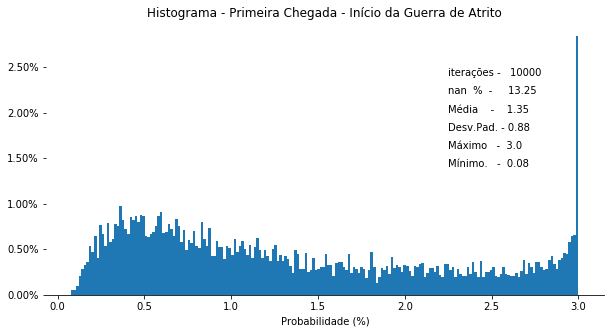

In [125]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)


ax.hist(a, bins=200, weights=np.ones(tamanho)/tamanho )
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel('Tempo')
ax.set_xlabel('Probabilidade (%)')

ax.text(2.25,.024,'iterações -   {}'.format(tamanho))
ax.text(2.25,.022,'nan  %  -     {}'.format(100*np.isnan(a).sum()/tamanho))
ax.text(2.25,.020,'Média    -    {}'.format(m))

ax.text(2.25,.018,'Desv.Pad. - {}'.format(dv))

ax.text(2.25,.016,'Máximo   -  {}'.format(ma))

ax.text(2.25,.014,'Mínimo.   -  {}'.format(mi))
#ax.set_xlim(right=72)
#ax.set_xlim(left=71)

#ax.set_ylim(top=1300)
#ax.set_ylim(bottom=1250)
ax.set_title('Histograma - Primeira Chegada - Início da Guerra de Atrito')

plt.plot()

In [105]:
sum(np.isnan(a)) + sum(a>0)

C:\Users\LG\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


10000

In [107]:
100*sum(a<1)/a.shape[0]

C:\Users\LG\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


38.8

In [108]:
100*sum(a>2.5)/a.shape[0]

C:\Users\LG\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


13.8

In [112]:
100*sum(np.logical_and(a>1, a<2.5))/a.shape[0]

C:\Users\LG\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
C:\Users\LG\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


34.15

In [115]:
####Conferir se todas as médidas
100*sum(a<1)/a.shape[0] +  100*sum(np.logical_and(a>1, a<2.5))/a.shape[0] +100*sum(a>2.5)/a.shape[0] +100*np.isnan(a).sum()/tamanho

C:\Users\LG\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
C:\Users\LG\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


99.99999999999999

In [98]:
sum(~np.isnan(a))

8675

In [72]:
print('Esperança matemática é:', P*np.exp(alpha*tau))
print('Média das simulações é',df.iloc[-1,2:].mean())

Esperança matemática é: 65.49822253666237
Média das simulações é 65.61384242154207


65.61384242154207

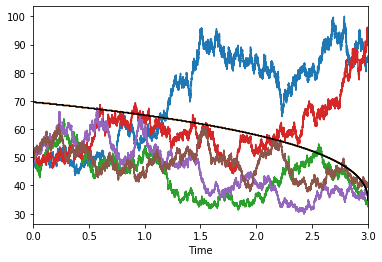

In [276]:
df.plot(legend=False)
df.Gatilho.plot(color='black')

In [121]:
g[-1]

34.82827296866603